# Import the necesary libraries


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import pmdarima as pmd
from statsmodels.tsa.arima.model import ARIMA

# Helper Functions



In [12]:
def plot_timeseries(xV, get_histogram=False, title='', savepath=''):
    # #plot timeseries
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    ax.plot(xV, marker='x', linestyle='--', linewidth=2);
    ax.set_xlabel('time')
    ax.set_ylabel('value')
    if len(title) > 0:
        ax.set_title(title, x=0.5, y=1.0);
    plt.tight_layout()
    if len(savepath) > 0:
        plt.savefig(f'{savepath}/{title}_xM.jpeg')
    # #plot histogram
    if get_histogram:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.hist(xV, alpha=0.8, rwidth=0.9);
        ax.set_xlabel('value')
        ax.set_title('Histogram')
        plt.tight_layout()
        if len(title) > 0:
            ax.set_title(title, x=0.5, y=1.0);
        plt.tight_layout()
        if len(savepath) > 0:
            plt.savefig(f'{savepath}/{title}_hist.jpeg')

def seasonal_components(xV, period):
    '''
    computes the periodic time series comprised of repetetive
    patterns of seasonal components given a time series and the season
    (period).
    '''
    n = xV.shape[0]
    sV = np.full(shape=(n,), fill_value=np.nan)
    monV = np.full(shape=(period,), fill_value=np.nan)
    for i in np.arange(period):
        monV[i] = np.mean(xV[i:n:period])
    monV = monV - np.mean(monV)
    for i in np.arange(period):
        sV[i:n:period] = monV[i] * np.ones(shape=len(np.arange(i, n, period)))
    return sV

def get_acf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate acf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    acfV = acf(xV, nlags=lags)[1:]
    z_inv = norm.ppf(1 - alpha / 2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, lags + 1), acfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1 - alpha) * 100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('ACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags + 1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return acfV


def get_pacf(xV, lags=10, alpha=0.05, show=True):
    '''
    calculate pacf of timeseries xV to lag (lags) and show
    figure with confidence interval with (alpha)
    '''
    pacfV = pacf(xV, nlags=lags, method='ols-adjusted')[1:]
    z_inv = norm.ppf(1 - alpha / 2)
    upperbound95 = z_inv / np.sqrt(xV.shape[0])
    lowerbound95 = -upperbound95
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(np.arange(1, lags + 1), pacfV, marker='o')
        ax.axhline(upperbound95, linestyle='--', color='red', label=f'Conf. Int {(1 - alpha) * 100}%')
        ax.axhline(lowerbound95, linestyle='--', color='red')
        ax.set_title('PACF')
        ax.set_xlabel('Lag')
        ax.set_xticks(np.arange(1, lags + 1))
        ax.grid(linestyle='--', linewidth=0.5, alpha=0.15)
        ax.legend()
    return pacfV

def portmanteau_test(xV, maxtau, show=False):
    '''
    PORTMANTEAULB hypothesis test (H0) for independence of time series:
    tests jointly that several autocorrelations are zero.
    It computes the Ljung-Box statistic of the modified sum of
    autocorrelations up to a maximum lag, for maximum lags
    1,2,...,maxtau.
    '''
    ljung_result = acorr_ljungbox(xV, lags=maxtau)
    
    # Extract the 'lb_stat' and 'lb_pvalue' columns from the DataFrame
    ljung_val = ljung_result['lb_stat'].values
    ljung_pval = ljung_result['lb_pvalue'].values
    
    if show:
        fig, ax = plt.subplots(1, 1)
        # # FOR DEBUGGING PURPOSES:
        # print(f"ljung_pval: {ljung_pval}")
        # print(f"np.arange(len(ljung_pval)): {np.arange(len(ljung_pval))}")
        ax.scatter(np.arange(len(ljung_pval)), ljung_pval)
        ax.axhline(0.05, linestyle='--', color='r')
        ax.set_title('Ljung-Box Portmanteau test')
        ax.set_yticks(np.arange(0, 1.1))
        plt.show()
    
    return ljung_val, ljung_pval


def arimamodel(xV):
    '''
    BUILT-IN SOLUTION FOR DETECTING BEST ARIMA MODEL MINIMIZING AIC
    https://alkaline-ml.com/pmdarima/index.html
    '''
    autoarima_model = pmd.auto_arima(xV,
                                     start_p=1, start_q=1,
                                     max_p=5, max_q=5,
                                     test="adf", stepwise=False,
                                     trace=True, information_criterion='aic')
    return autoarima_model

def fit_arima_model(xV, p, q, d=0, show=False):
    '''
    fit ARIMA(p, d, q) in xV
    returns: summary (table), fittedvalues, residuals, model, AIC
    '''
    try:
        model = ARIMA(xV, order=(p, d, q)).fit()
    except:
        return np.nan
    summary = model.summary()
    fittedvalues = model.fittedvalues
    fittedvalues = np.array(fittedvalues).reshape(-1, 1)
    resid = model.resid
    if show:
        fig, ax = plt.subplots(1, 1, figsize=(14, 8))
        ax.plot(xV, label='Original', color='blue')
        ax.plot(fittedvalues, label='FittedValues', color='red', linestyle='--', alpha=0.9)
        ax.legend()
        ax.set_title(f'ARIMA({p}, {d}, {q})')
        fig, ax = plt.subplots(2, 1, figsize=(14, 8))
        ax[0].hist(resid, label='Residual')
        ax[1].scatter(np.arange(len(resid)), resid)
        ax[1].axhline(0, linestyle='--', color='red')
        plt.title('Residuals')
        plt.legend()
    return summary, fittedvalues, resid, model, model.aic




# Preprocess the data

In [13]:
data_df = pd.read_csv('train.csv')
team_number = 11
team_data = data_df.iloc[:, team_number + 1]

#turn the data into a numpy array
team_data = team_data.to_numpy()

#find the consecutive values
same_val_index = np.where(np.diff(team_data) == 0)

print(f"Value {team_data[same_val_index[0][0]]} at index {same_val_index[0][0]} ")
print(f"Value {team_data[same_val_index[0][0] + 1]} at index {same_val_index[0][0] + 1} ")
print(f"Value {team_data[same_val_index[0][1]]} at index {same_val_index[0][1]} ")
print(f"Value {team_data[same_val_index[0][1] + 1]} at index {same_val_index[0][1] + 1} ")

# Replace the consecutive values with the mean of two values
#check if index - 365 < 0 and index + 365 > len(team_data)

for index in same_val_index[0]:
    if index - 365 < 0:
        print(f"First year of data.")
        team_data[index+1] = team_data[index+1+365]
    elif index + 365 > len(team_data):
        print(f"Last year of data.")
        team_data[index+1] = team_data[index+1-365]
    else:
        print(f"Middle of data.")
        team_data[index+1] = (team_data[index+1-365] + team_data[index+1+365])/2



    






Value 24058500 at index 89 
Value 24058500 at index 90 
Value 12694200 at index 388 
Value 12694200 at index 389 
First year of data.
Middle of data.


In [14]:
A = np.copy(team_data)


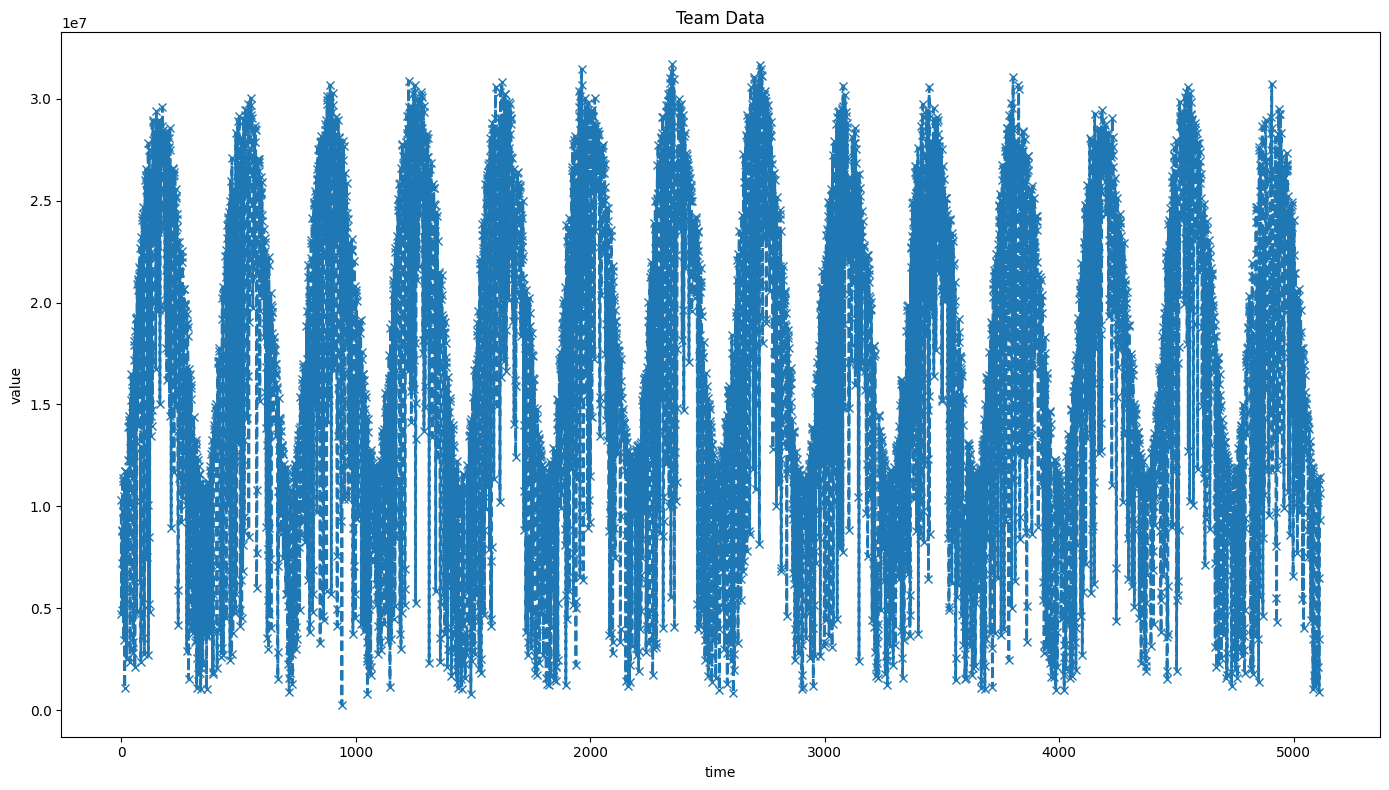

In [15]:
plot_timeseries(A,title='Team Data')

# Question 1

- Assume that A has no trend
- Remove Seasonality (can assume that s = 365)

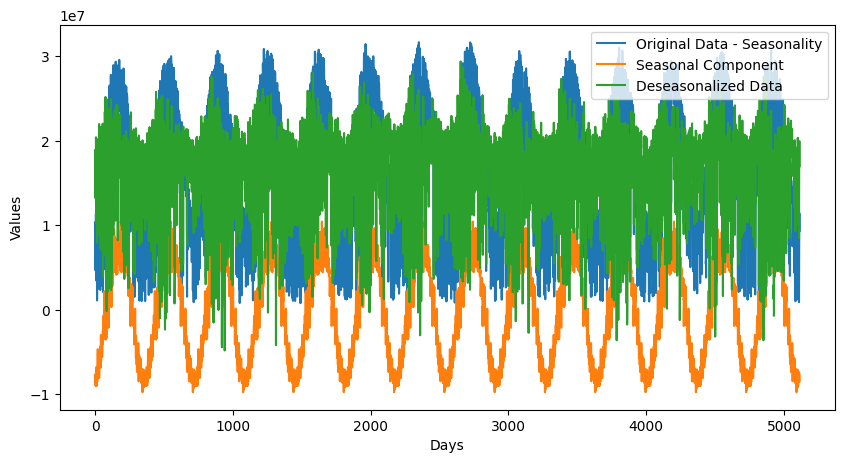

In [16]:
# just subtract s =365
T_season = 365
s = seasonal_components(A, T_season)
A_static= A - s
plt.figure(figsize=(10,5))
plt.plot(A,label='Original Data - Seasonality')
plt.plot(s,label="Seasonal Component")
plt.plot(A_static,label='Deseasonalized Data')
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.show()



# Question 2

- Investigate if the `A_static` is White Noise (WN).
- A time series is considered White Noise (WN) if it satisfies the following conditions:

  1. **Mean**:
     $$
     E[X_t] = 0, \quad \text{for each } t.
     $$

  2. **Variance**:
     $$
     \text{Var}[X_t] = \sigma^2, \quad \text{constant for each } t.
     $$

  3. **Covariance**:
     $$
     \text{Cov}(X_t, X_{t+k}) = 0, \quad \text{the observations are independent from one another.}
     $$


- So i will plot the autocorrelation figure and i will check if the autocorrelation is within the confidence interval.
- Another way to check the above is to use the portmanteau test

Mean of the A_Static timeseries: 16659027.76
Variance of the A_Static timeseries: 28298116893018.30


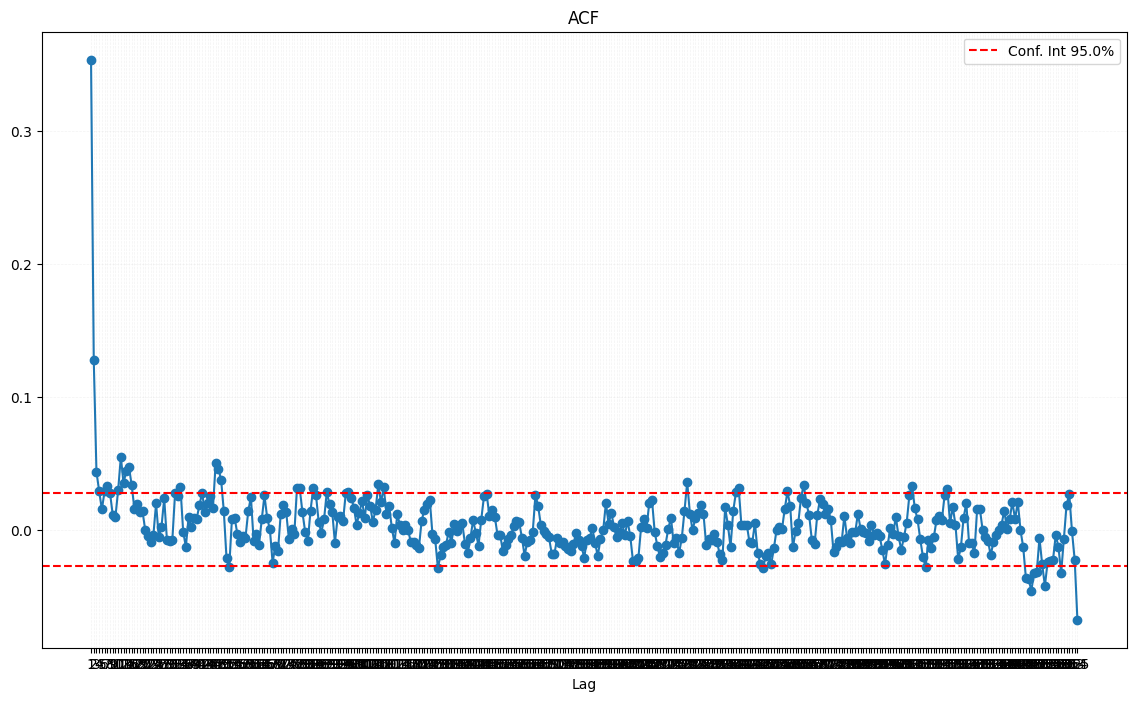

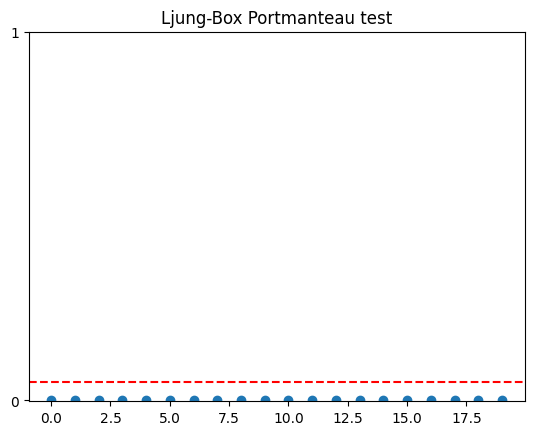

Reject the null hypothesis that the time series is independently distributed.


In [17]:
# Check the mean
print(f"Mean of the A_Static timeseries: {np.mean(A_static):.2f}")

# Check the variance
print(f"Variance of the A_Static timeseries: {np.var(A_static):.2f}")

# Check the autocorrelation
acfV = get_acf(A_static, lags=365, alpha=0.05, show=True)

#Check the portmanteau test
ljung_val, ljung_pval = portmanteau_test(A_static, maxtau=20, show=True)

if np.any(ljung_pval < 0.05):
    print(f"Reject the null hypothesis that the time series is independently distributed.")
else:
    print(f"Accept the null hypothesis that the time series is independently distributed.")

# Question 3

- Find the best linear model for `A_static`.
- To be this model appropriate, its residuals should be WN

In [18]:
best_linear_model = arimamodel(A_static) #no trend in the data
print(best_linear_model.summary())


 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=172883.189, Time=0.05 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_

 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=172293.232, Time=0.18 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=172219.518, Time=0.27 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=172215.076, Time=0.29 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=172212.250, Time=0.41 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=172213.755, Time=0.44 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=172203.276, Time=0.12 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=172205.252, Time=0.21 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=172207.233, Time=0.38 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=172208.664, Time=0.46 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=172209.922, Time=0.63 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=172205.219, Time=0.14 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=172207.220, Time=0.38 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=172209.188, Time=0.78 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=172209.160, Time=1.64 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=172207.169, Time=0.23 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,1)(0,0,0)[1] intercept   : AIC=172209.170, Time=0.74 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,0,2)(0,0,0)[1] intercept   : AIC=172210.999, Time=0.72 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,0)(0,0,0)[1] intercept   : AIC=172207.835, Time=0.25 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,0,1)(0,0,0)[1] intercept   : AIC=172209.835, Time=0.86 sec


c:\Users\xkoun\anaconda3\envs\MachineLearning\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,0,0)(0,0,0)[1] intercept   : AIC=172209.835, Time=0.32 sec

Best model:  ARIMA(1,0,0)(0,0,0)[1] intercept
Total fit time: 9.517 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 5113
Model:               SARIMAX(1, 0, 0)   Log Likelihood              -86098.638
Date:                Wed, 15 Jan 2025   AIC                         172203.276
Time:                        13:50:22   BIC                         172222.894
Sample:                             0   HQIC                        172210.144
                               - 5113                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.077e+07   2.37e-10   4.54e+16      0.000    1.08e+0

C:\Users\xkoun\AppData\Local\Temp\ipykernel_63384\3808543417.py:148: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


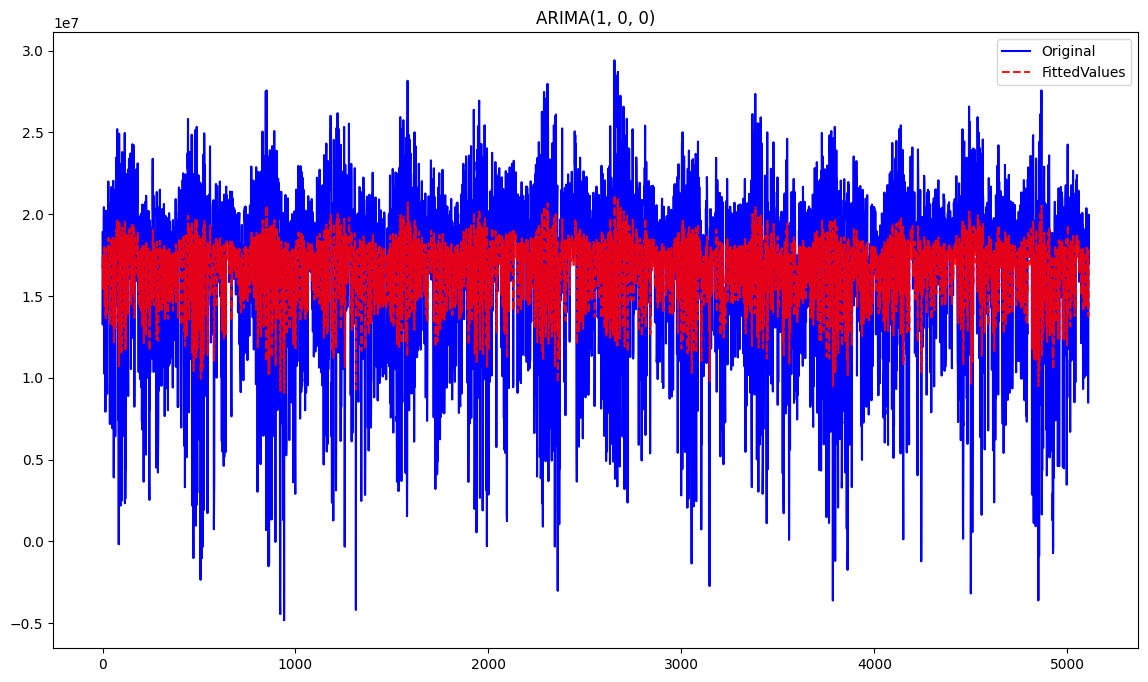

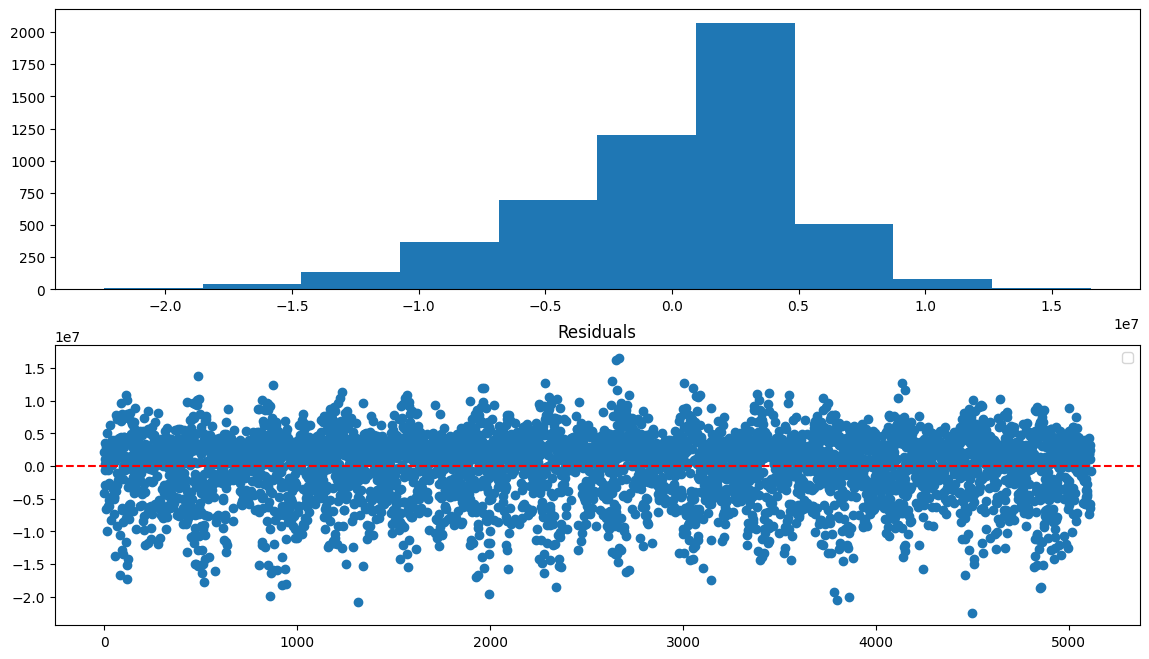

In [19]:
best_p = best_linear_model.order[0]
best_q = best_linear_model.order[2]
summary, fittedvalues,resid,model,aic = fit_arima_model(A_static, best_p, best_q, d=0, show=True)

Mean of the residuals: 23.83
Variance of the residuals: 24764360836694.09


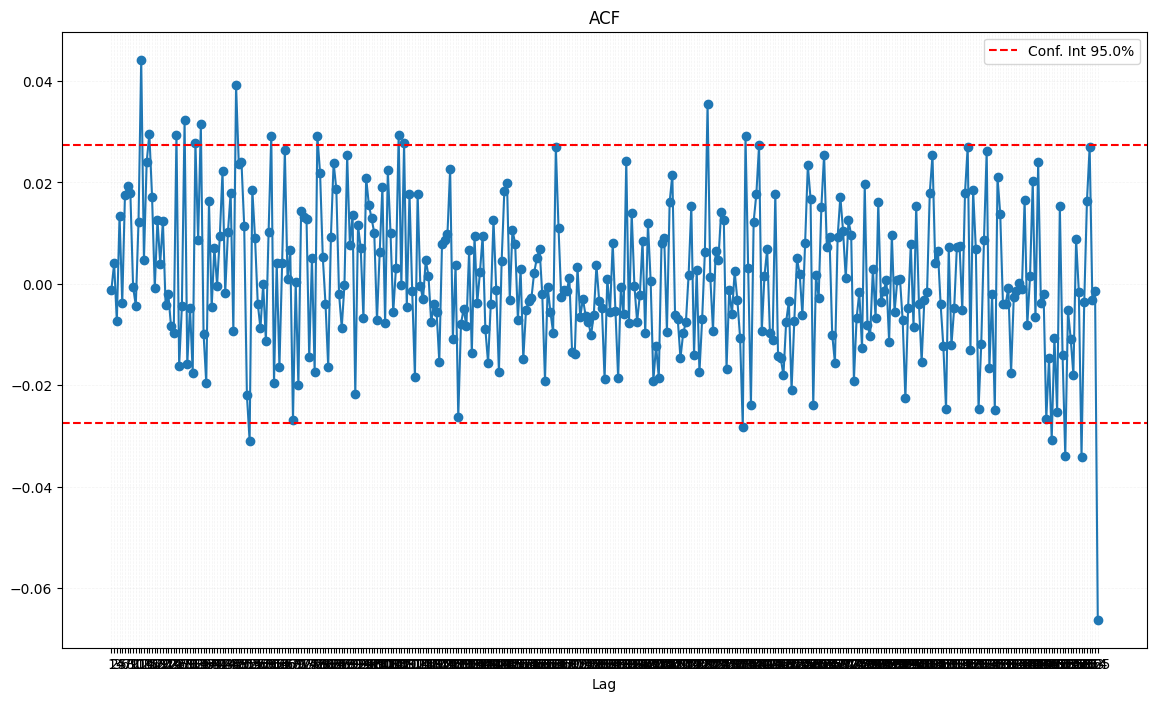

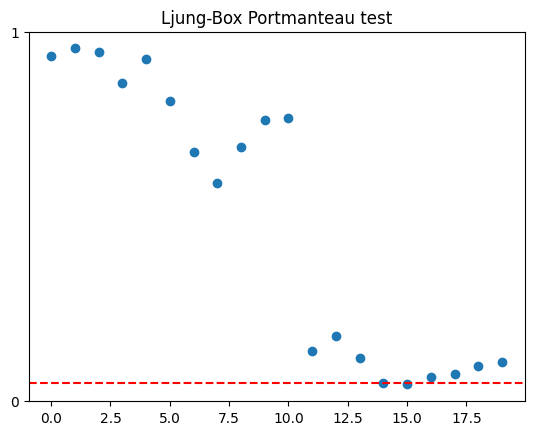

Reject the null hypothesis that the time series is independently distributed.


In [20]:
# Check if the residuals are white noise
print(f"Mean of the residuals: {np.mean(resid):.2f}")   
print(f"Variance of the residuals: {np.var(resid):.2f}")
acfV = get_acf(resid, lags=365, alpha=0.05, show=True)

#Check the portmanteau test
ljung_val, ljung_pval = portmanteau_test(resid, maxtau=20, show=True)
if np.any(ljung_pval < 0.05):
    print(f"Reject the null hypothesis that the time series is independently distributed.")
else:
    print(f"Accept the null hypothesis that the time series is independently distributed.")